# Jupyter Notebook for Validation of Results

## Overview

This notebook compares the results obtained from the two implementations, `shbundle` and `pyshbundle`, for a specific task.<br>We will focus on evaluating the following:
- Root Mean Squared Error (RMSE)
- Normalized Root Mean Squared Error (NRMSE)
- the difference in time series for a given basin.

## Evaluation Metrics

### 1. Root Mean Squared Error (RMSE)

The RMSE is a measure of the average magnitude of the errors between predicted and observed values.<br> It is calculated as follows:

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i - \bar{y}}\Big)^2}}$$

where:
- $n$ is the number of observations
- ${y_i}$ is the $i_{th}$ observation
- $\bar{y}$ is the mean of observations

### 2. Normalized Root Mean Squared Error (NRMSE)

NRMSE is a normalized version of RMSE, which provides a relative measure of the error compared to the range of the observed values. It is calculated as:

$$ NRMSE = \frac{RMSE}{\max(y) - \min(y)}$$

### 3. Difference in Time Series

We will also visually inspect the difference in time series obtained from both methods to identify any patterns or discrepancies.


## Data Preparation

Before proceeding with the analysis, ensure that the data from both `shbundle` and `pyshbundle` are loaded into the notebook.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# import proplot
import os
from pyshbundle.hydro import BasinAvg
# import BasinAvg

Initializing PySHbundle v0.2.1


Load the pre computed TWS outputs of SHBundle from the validation data folder - These have been computed using the JPL Solutions

In [2]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
from scipy.io import loadmat
# Load the .mat file - generated by SHBundle Matlab/Octave
data_matlab = loadmat('../pyshbundle/validation_data/tws_m.mat')
# Access the variables in the .mat file
tws_mat = data_matlab['tws_m']

# Global TWS Anomaly field - computed using PySHBundle
data_py_jpl = xr.open_dataset('../pyshbundle/validation_data/tws_py.nc', engine="netcdf4")
tws_py_jpl = data_py_jpl.tws

In [3]:
data_py_jpl.attrs

{'description': 'TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km'}

Computing the TWS from scratch using the new codes follow the steps outlined in the TWS_timeseries notebook

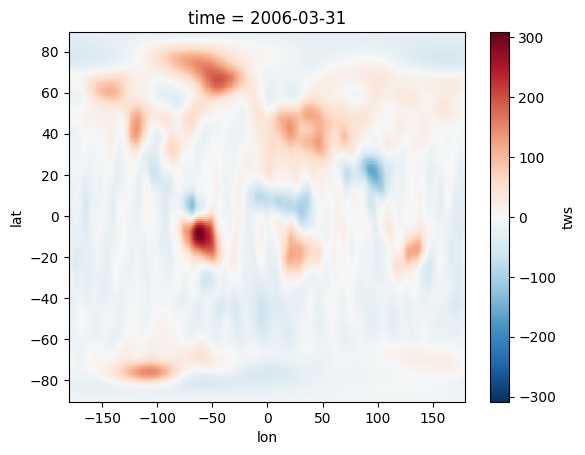

In [4]:
# Visualization
data_py_jpl.tws[50].plot()

In [5]:
# The PySHBundle TWS output is also of 1 deg spacing
data_py_jpl.tws[50].shape

(180, 360)

In [6]:
# The SHBundle matrix -> 1 deg spacing
(tws_mat[50, :, :]).shape

(180, 360)

In [7]:
# Transforming the SHBundle TWS Anomaly into NetCDF format to provide geocoding to the gridded TWS Anomalies

# gridsize is 1 deg which was used to compute earlier
gs = 1
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
'''
tws_py_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
'''

data_m_jpl = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], tws_mat)
    ),
    coords = {
        "time":(('time'),data_py_jpl.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(description="TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km"),
)
data_m_jpl.attrs

{'description': 'TWS Anomaly corresponding to long term (2004-2010) mean \n lmax=96 and half radius of Gaussian filter = 500Km'}

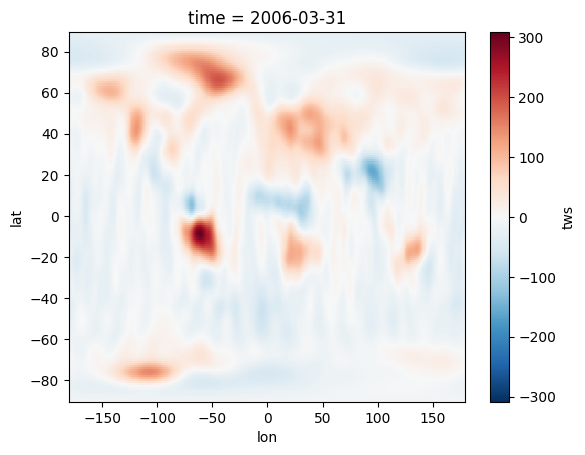

In [8]:
data_m_jpl.tws.isel(time=50).plot()
plt.show()

### Gridwise RMSE calculation`

#### Creating a mask to remove the months of data which is missing (NaN)

In [9]:
nan_mask = np.all(np.isnan(data_py_jpl.tws.values), axis=(1, 2))
nan_mask

array([ True,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False,  True, False, False, False, False,  True,  True,  True,
        True, False,

In [10]:
tws_py_jpl[~nan_mask].shape   # we see that the size of data has reduced to 196 months

(196, 180, 360)

Now that 

In [11]:
tws_m_jpl = data_m_jpl.tws

In [12]:
diff = tws_py_jpl[~nan_mask] - tws_m_jpl[~nan_mask]
squared_diff = diff**2

mean_squared_diff = np.mean(squared_diff, axis=0)
rmse = np.sqrt(mean_squared_diff)
nrmse = rmse/np.std(tws_py_jpl[~nan_mask], axis=0)
std_ = np.std(tws_py_jpl[~nan_mask], axis=0)

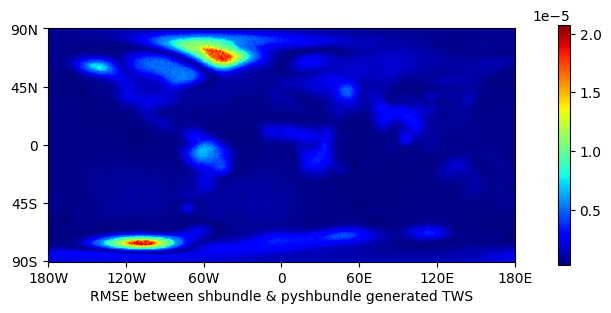

In [13]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=100, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(rmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


#plt.savefig('../pyshbundle/pic/02_error_rmse.png')
plt.show()

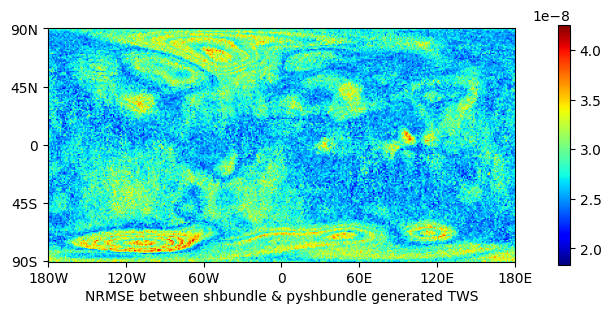

In [14]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=100, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax1.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax1.imshow(nrmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('NRMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=-0.2)


#plt.savefig('../pyshbundle/pic/02_error_nrmse.png')
plt.show()

### `Basin avg RMSE`

In [15]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping

In [16]:
# import shapefile
path='../pyshbundle/data/basin_shapefiles/krishna_basin.shp'
krishna_shp = gpd.read_file(path)

NOTE: In order to measure areas from these geometries the appropriate system EPSG:32644 - WGS 84 / UTM zone 44N

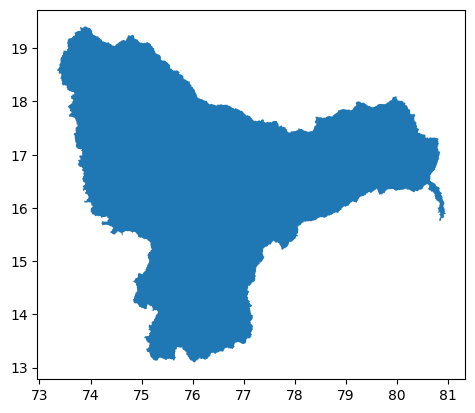

In [17]:
krishna_shp.plot()
plt.show()

In [18]:
(data_py_jpl.tws).shape

(252, 180, 360)

In [19]:
# its WGS84
krishna_shp.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
krishna_shp.to_crs('epsg:32644', inplace=True)


In [21]:
# in m^2
basin_area = krishna_shp.area.sum()
print(f'{basin_area/(10**6)} km2')

259412.73935151333 km2


In [22]:
tws_py_jpl = tws_py_jpl*basin_area
tws_m_jpl = tws_m_jpl*basin_area

Area of basin in km2: 259412.73935151333


/home/mn5hk/venvs/pysh/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


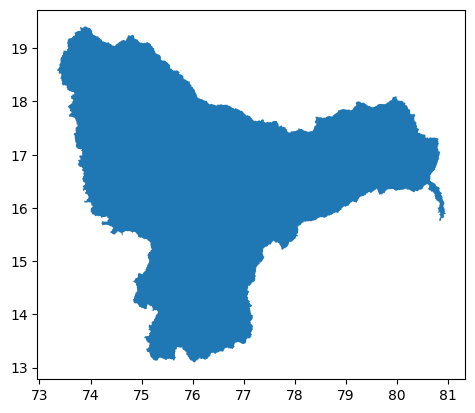

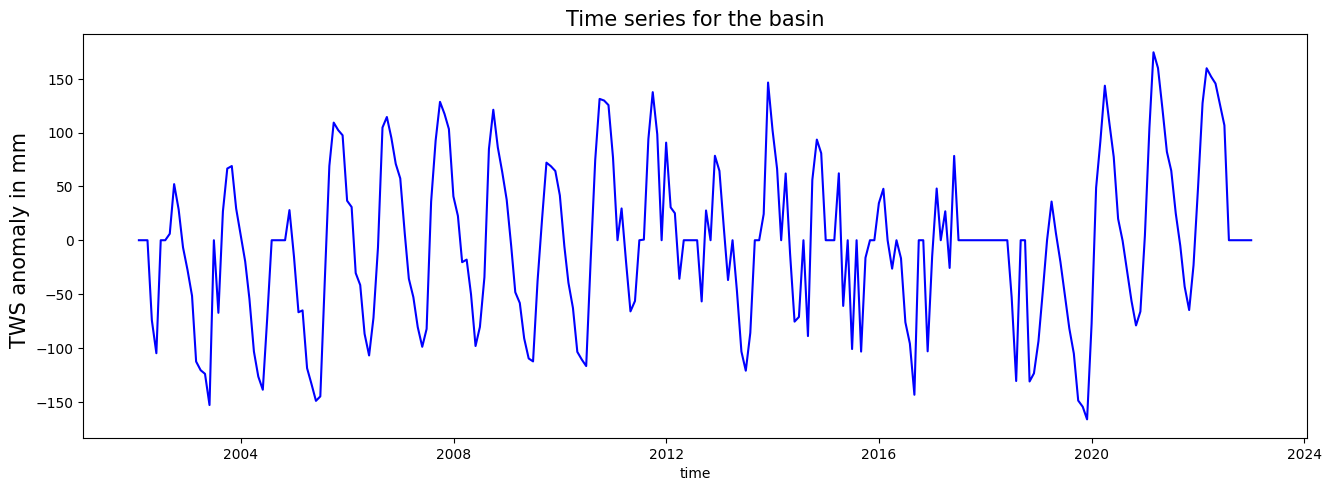

In [23]:
basin_tws_py_jpl, data_vars_py = BasinAvg(data_py_jpl, path, 'epsg:32644', 252, 1)

In [24]:
type(data_vars_py)

xarray.core.dataset.Dataset

The default plot is not great... it can be imporved easily

Similarly for the data from matlab

In [25]:
data_m_jpl.tws.shape

(252, 180, 360)

Area of basin in km2: 259412.73935151333


/home/mn5hk/venvs/pysh/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


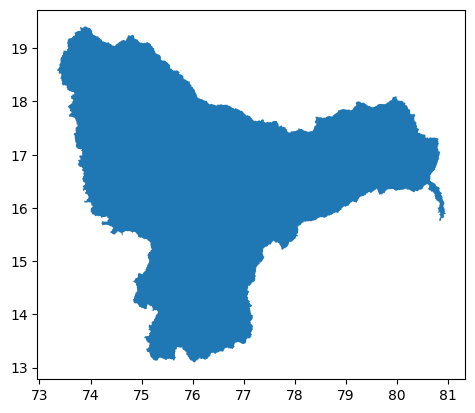

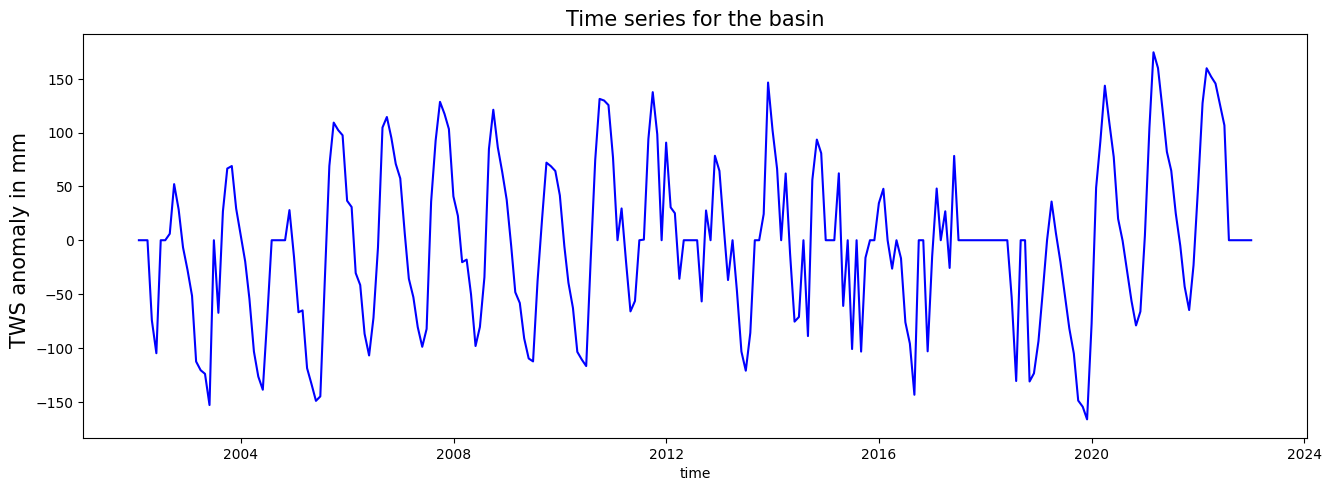

In [26]:
basin_tws_m_jpl, data_vars_m = BasinAvg(data_m_jpl, path, 'epsg:32644', 252, 1)

In [27]:
# clip data using shapefile
''' add projection system to nc '''
basin_tws_py_jpl_ = tws_py_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_py_jpl_ = basin_tws_py_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
basin_tws_m_jpl_ = tws_m_jpl.rio.write_crs("EPSG:4326", inplace=True)
basin_tws_m_jpl_ = basin_tws_m_jpl_.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        
# mask data with shapefile
basin_tws_py_jpl = basin_tws_py_jpl_.rio.clip(krishna_shp.geometry.apply(mapping), krishna_shp.crs,drop=False)
basin_tws_m_jpl = basin_tws_m_jpl_.rio.clip(krishna_shp.geometry.apply(mapping), krishna_shp.crs,drop=False)

basin_avg_tws_py_jpl = basin_tws_py_jpl.sum(dim = ('lon','lat'), skipna = True)/basin_area
basin_avg_tws_m_jpl = basin_tws_m_jpl.sum(dim = ('lon','lat'), skipna = True)/basin_area

In [28]:
# diff of shbundle and pyshbundle
diff_basin_avg_tws = basin_tws_m_jpl -basin_tws_py_jpl

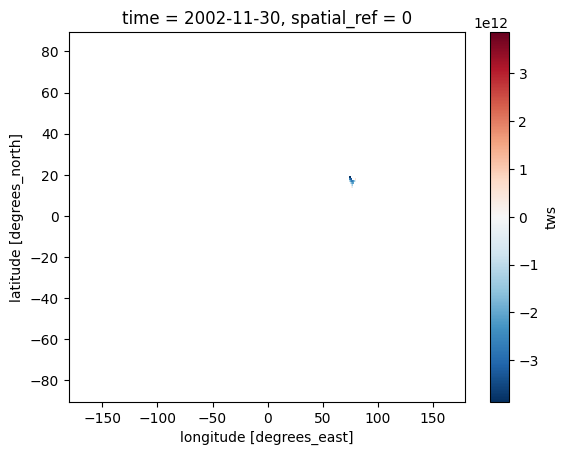

In [29]:
basin_tws_py_jpl.isel(time=10,).plot()

In [30]:
diff_basin_avg_tws

<xarray.DataArray 'tws' (time: 252, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat          (lat) int64 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon          (lon) int64 -180 -179 -178 -177 -176 ... 175 176 177 178 179
    spatial_ref  int64 0

In [31]:
nan_mask_reshaped = np.expand_dims(nan_mask, axis=(1, 2))

In [32]:
basin_avg_tws_py_jpl = data_vars_py.where(~nan_mask_reshaped, np.nan)
basin_avg_tws_m_jpl = data_vars_m.where(~nan_mask_reshaped, np.nan)


In [33]:
diff_basin_avg_tws[nan_mask]=np.nan
diff_basin_avg_tws

<xarray.DataArray 'tws' (time: 252, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2002-01-31 2002-02-28 ... 2022-12-31
  * lat          (lat) int64 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon          (lon) int64 -180 -179 -178 -177 -176 ... 175 176 177 178 179
    spatial_ref  int64 0

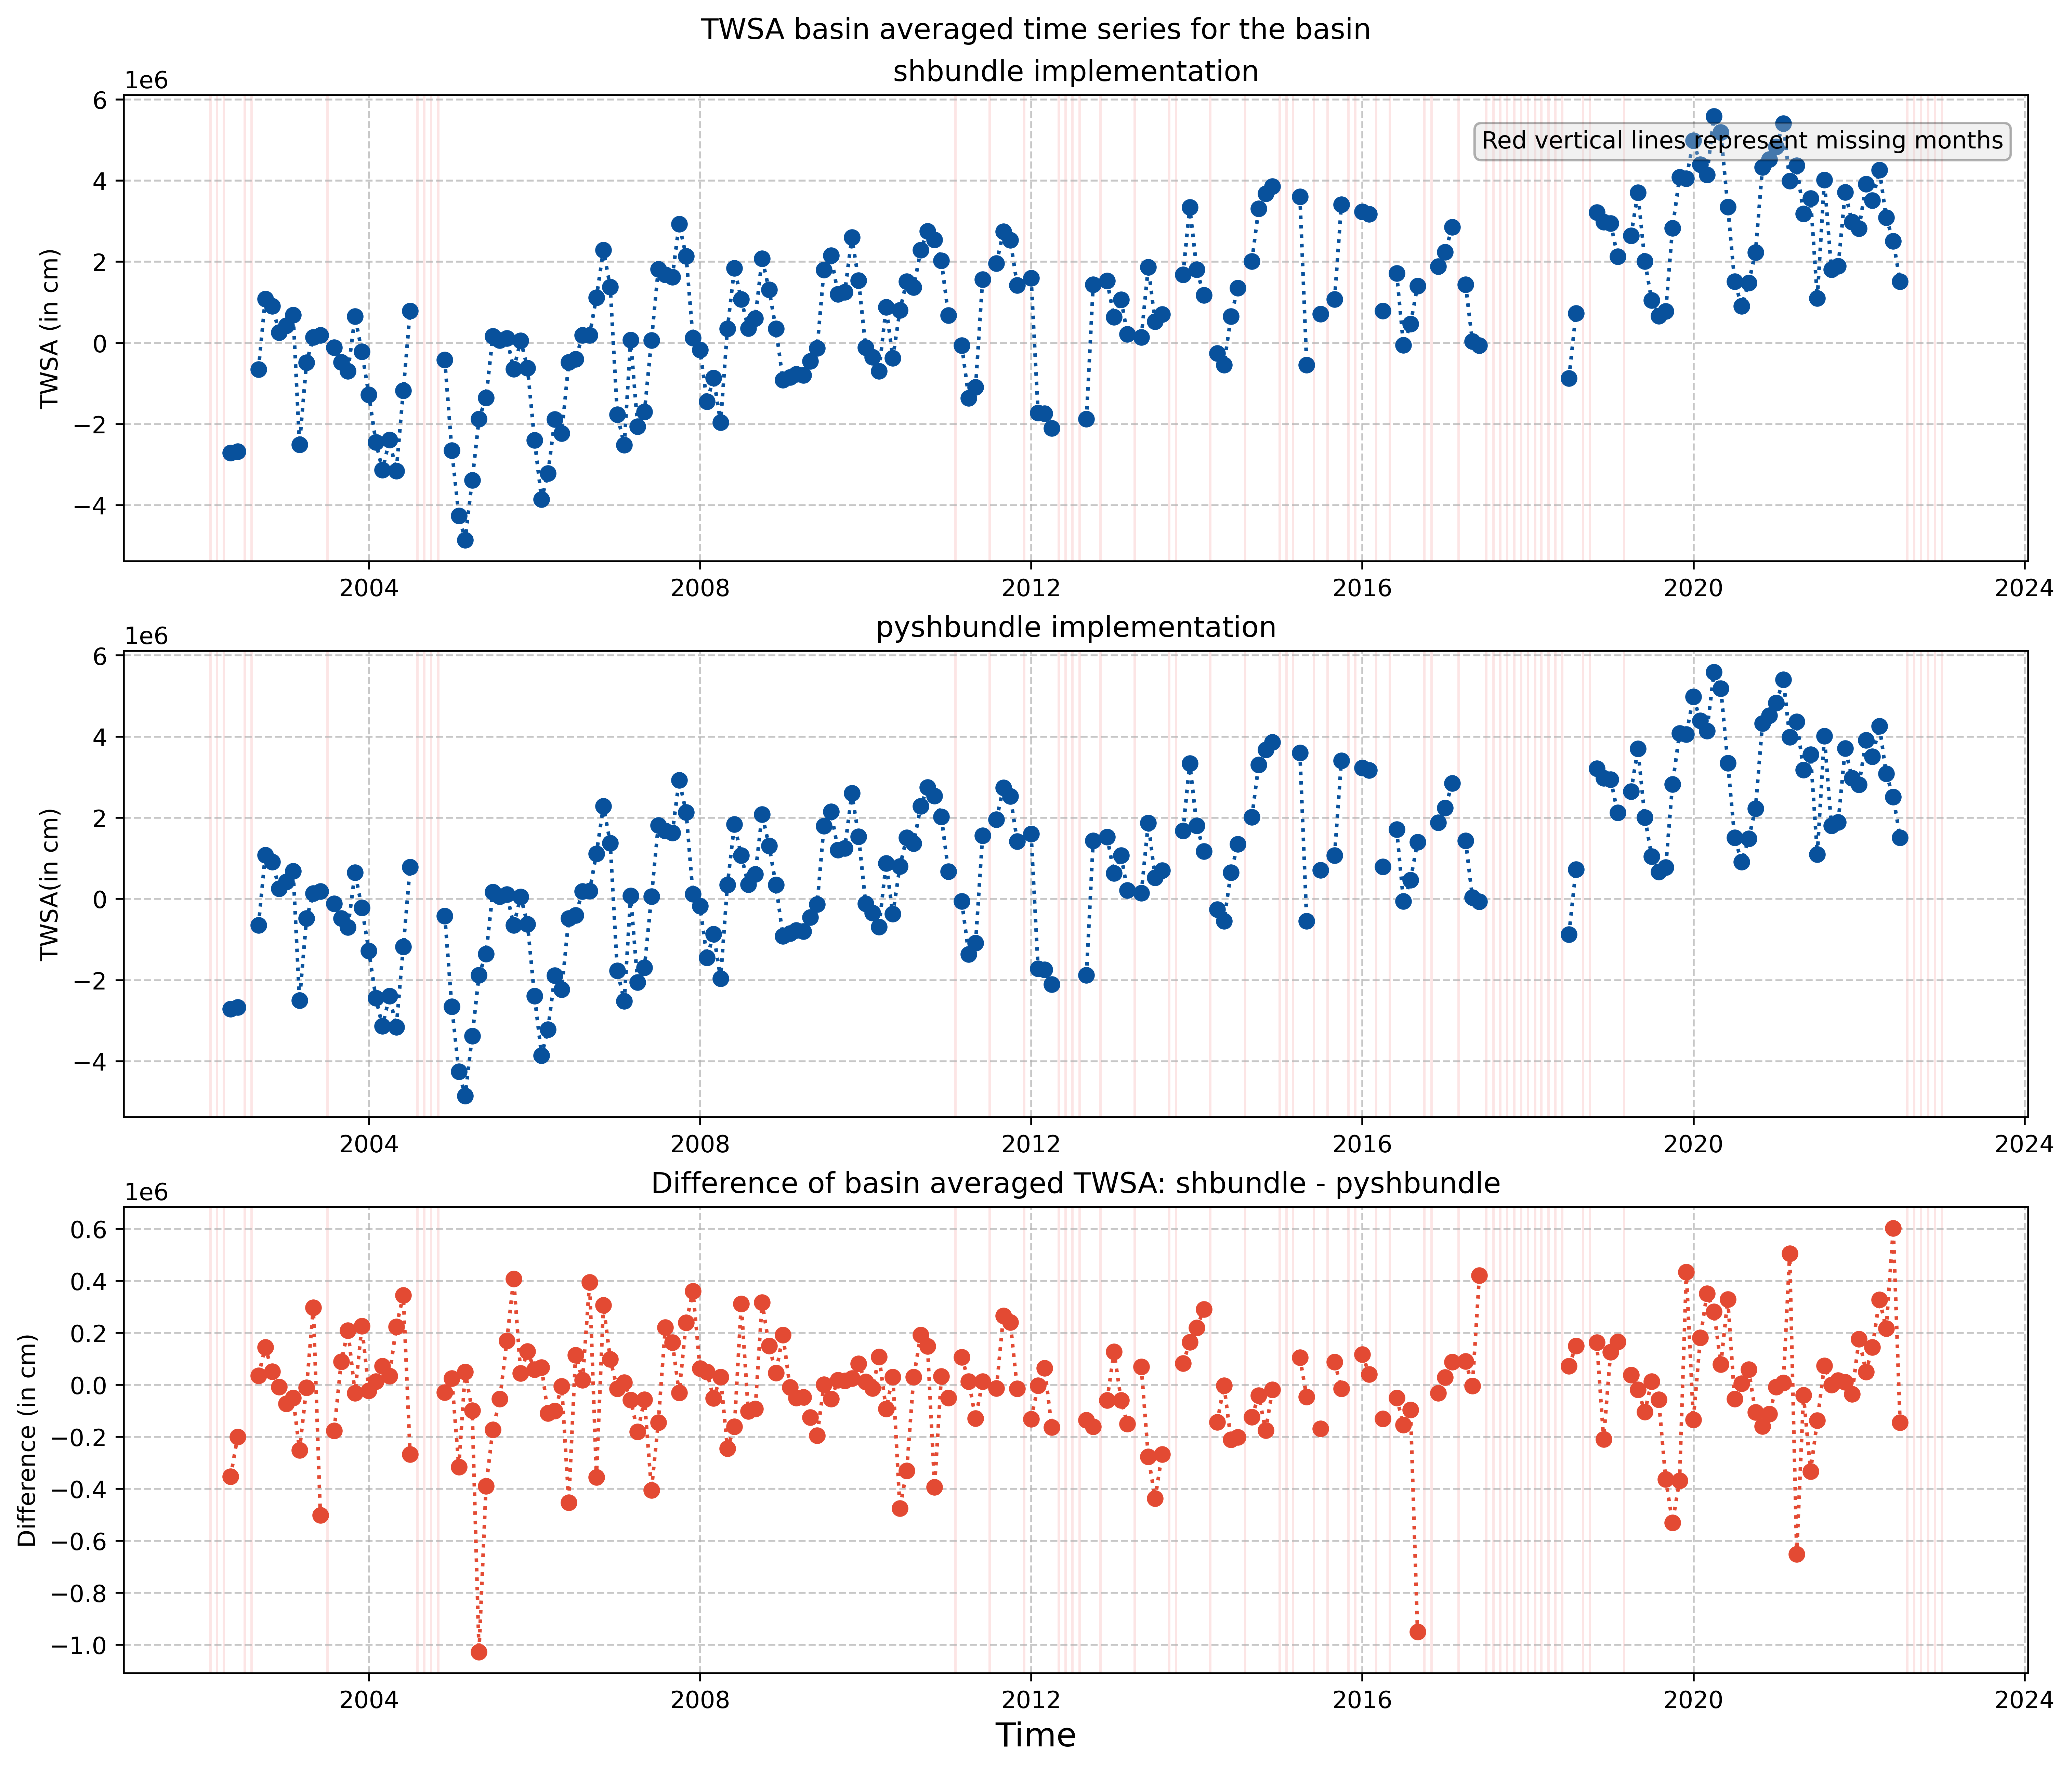

In [34]:
# Create lists for each data
data_list = [basin_avg_tws_m_jpl.tws, basin_avg_tws_py_jpl.tws, diff_basin_avg_tws]  
label_list = ['shbundle implementation', 'pyshbundle implementation','Difference of basin averaged TWSA: shbundle - pyshbundle']
# legend_list = ['Monthly TWSA', 'Monthly TWSA', 'Difference in monthly']
color_list = ['#08519c', '#08519c', '#e34a33']
ylabel_list = ['TWSA (in cm)', 'TWSA(in cm)', 'Difference (in cm)']

# Create subplots with three rows and one column
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), constrained_layout=True, dpi=500)

# Iterate over each subplot
for i, ax in enumerate(axes):
    # Plot with a dotted line and markers
    ax.plot(data_list[0].time, np.mean(data_list[i], axis = (1,2)), 
            label=label_list[i], linestyle='dotted', marker='o', color=color_list[i])

    # Create vertical shaded regions for missing values
    nan_variables = data_list[0].time.values[nan_mask]
    for xc in nan_variables:
        ax.axvspan(xc, xc, color='lightcoral', alpha=0.2)

    # Add labels and title

    ax.set_ylabel(ylabel_list[i])
    ax.set_title(f'{label_list[i]}')

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a legend
    # ax.legend(fancybox=True, edgecolor='black', loc="upper left")
    # Add text box only in the first subplot
    if i == 0:
        ax.text(
            0.85, 0.9,  # Position of the text box (relative to the subplot)
            'Red vertical lines represent missing months',  # Text content
            transform=ax.transAxes,  # Specify that coordinates are in axes-relative coordinates
            ha='center', va='center',  # Center the text
            bbox=dict(boxstyle='round', facecolor='lightgrey', edgecolor='black', alpha=0.3)  # Add a rounded box around the text
        )
# Show the plot
# Add a common x-axis label for all subplots
fig.text(0.5, -0.01, 'Time', ha='center', va='center', fontsize=14)
# fig.suptitle(f'TWSA basin averaged time series for {basin_name}')
fig.suptitle(f'TWSA basin averaged time series for the basin')
plt.show()
# fig.savefig(f'../pyshbundle/pic/03_basin_avg_tws_{basin_name}.png')